In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shelve
import numba as nb
import math
import soundfile as sf


from mutagen.mp3 import MP3 
from PIL import Image 
from pathlib import Path 
import os 
import imageio 
from moviepy import editor 

In [2]:
class kuramoto_reservoir:
    def __init__(self, w, h, p,x0,Wout):
        self.w = w
        self.x0 = x0 
        self.N = len(w)
        self.Wout = Wout
        self.h = h
        self.X=x0
        self.p=p
        
    def solve(self, m_test = 10_000):
        U_pred = np.zeros(m_test,dtype='float64')
        t=0
        for i in range(0,m_test):
            t=self.h+t
            self.X = varRK4(t, self.X, self.h, fkura_closed, self.p, self.Wout,self.w,self.N)
            xstate = concat_nb0(np.sin(self.X), np.sin(self.X)**2)
            Up= nb_concatdot30(self.Wout, xstate)
            U_pred[i]= Up  
        return  U_pred
             
@nb.njit()
def fkura_closed(t,x,p,Wout,w,N):
    uin, K,F = p[0],p[1],p[2]
    y = np.empty(N,dtype='float64')
    R1=0
    R2=0
    Up0= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))
    for i in nb.prange(N):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(N):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(Up0*uin-x[i])       
    return y

@nb.njit()
def varRK4(t, state, dt, f, p, Wout,w,N):
    tmid = t + dt*0.5
    k1 = dt*fkura_closed(t,state,p,Wout,w,N) 
    k2 = dt*fkura_closed(t,state + 0.5 * k1,p,Wout,w,N)
    k3 = dt*fkura_closed(t,state + 0.5 * k2,p,Wout,w,N) 
    k4 = dt*fkura_closed(t + dt ,state + k3,p,Wout,w,N)
    y= (state + (1.0/6.0) * (k1 + 2*k2 + 2*k3 + k4))
    return ( y % (2*math.pi))

@nb.njit()
def concat_nb0(x,y):
    res = np.empty( (x.shape[0]+y.shape[0]),dtype='float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i] = x[i]
        else:
            res[i] = y[i- x.shape[0] ]
    return res 

@nb.njit()
def nb_concatdot30( x, y): 
    res = 0
    for i in nb.prange(x.shape[0]):
        if i==0:
            res+=x[i]
        else:
            res+=x[i]*y[i-1]
    return res          

def scale_shift(x):
    return (x-0.1)/10
 

In [3]:
class circ_rot():
    def __init__(self,center):
        self.step = 0
        self.center = center
        self.pos = [center[0],0.3+center[1]]
    
    def one_step(self):
        self.step+=1
        return  [0.3*np.sin(2*np.pi*self.step/5) + self.center[0],0.3*np.cos(2*np.pi*self.step/5) +self.center[1]]

In [4]:
with shelve.open('shelve/sound_param.shelve', 'r') as shelf:
    pa_dict,ra_dict = shelf['A'][0],shelf['A'][1]
    pc_dict,rc_dict = shelf['C'][0],shelf['C'][1]
    pd_dict,rd_dict = shelf['D'][0],shelf['D'][1]
    pe_dict,re_dict = shelf['E'][0],shelf['E'][1]
    pf_dict,rf_dict = shelf['F'][0],shelf['F'][1]
    pg_dict,rg_dict = shelf['G'][0],shelf['G'][1]

with shelve.open('shelve/sheet_param.shelve', 'r') as shelf:
    pM_dict,rM_dict = shelf['beat'][0], shelf['beat'][1]
    pB_dict,rB_dict = shelf['degree'][0],shelf['degree'][1] 

In [5]:
kA = kuramoto_reservoir(pa_dict['w'],pa_dict['h'],np.array([pa_dict['uin'],pa_dict['K'],pa_dict['F']]),\
                   ra_dict['x0'],ra_dict['Wout'])

kF = kuramoto_reservoir(pf_dict['w'],pf_dict['h'],np.array([pf_dict['uin'],pf_dict['K'],pf_dict['F']]),\
                   rf_dict['x0'],rf_dict['Wout'])

kG = kuramoto_reservoir(pg_dict['w'],pg_dict['h'],np.array([pg_dict['uin'],pg_dict['K'],pg_dict['F']]),\
                   rg_dict['x0'],rg_dict['Wout'])

kC = kuramoto_reservoir(pc_dict['w'],pc_dict['h'],np.array([pc_dict['uin'],pc_dict['K'],pc_dict['F']]),\
                   rc_dict['x0'],rc_dict['Wout'])

kD = kuramoto_reservoir(pd_dict['w'],pd_dict['h'],np.array([pd_dict['uin'],pd_dict['K'],pd_dict['F']]),\
                   rd_dict['x0'],rd_dict['Wout'])

kE = kuramoto_reservoir(pe_dict['w'],pe_dict['h'],np.array([pe_dict['uin'],pe_dict['K'],pe_dict['F']]),\
                   re_dict['x0'],re_dict['Wout'])

kM = kuramoto_reservoir(pM_dict['w'],pM_dict['h'],np.array([pM_dict['uin'],pM_dict['K'],pM_dict['F']]),\
                   rM_dict['x0'],rM_dict['Wout'])

kB = kuramoto_reservoir(pB_dict['w'],pB_dict['h'],np.array([pB_dict['uin'],pB_dict['K'],pB_dict['F']]),\
                   rB_dict['x0'],rB_dict['Wout'])

In [6]:
M_raw=kM.solve(m_test=10_000)
B_raw=kB.solve(m_test=10_000)

In [7]:
M_pro= np.round(M_raw[27*5-1::5][:100]+2)  
B_pro= np.round(B_raw[27*5-1::5][:100]+2) 
# at 27*5-1 the melody starts,
#for the trained data -2 was substracted otherwise the signal is too lopsided
#hence we need to add +2 to get the original signal

In [8]:
int2let = {1: 'C',  2:'D', 3: 'E', 4:'F', 5:'G',6: 'A'}

In [9]:

m_test = 4_000
sound_list = np.array([])
for m,b in zip(M_pro[:27],B_pro[:27]):
    b=int(b)
    if int2let[int(m)] =='A':
        mdum = scale_shift(kA.solve(m_test*b))
        mdum[-500:-250]= mdum[-500:-250]/2
        mdum[-250:] = 0
        sound_list = np.append(sound_list,mdum)
    elif int2let[int(m)] =='F':
        mdum = scale_shift(kF.solve(m_test*b))
        mdum[-500:-250]= mdum[-500:-250]/2
        mdum[-250:] = 0
        sound_list = np.append(sound_list,mdum)
    elif int2let[int(m)] =='C':
        mdum = scale_shift(kC.solve(m_test*b))
        mdum[-500:-250]= mdum[-500:-250]/2
        mdum[-250:] = 0
        sound_list = np.append(sound_list,mdum)
    elif int2let[int(m)] =='D':
        mdum = scale_shift(kD.solve(m_test*b))
        mdum[-500:-250]= mdum[-500:-250]/2
        mdum[-250:] = 0
        sound_list = np.append(sound_list,mdum)
    elif int2let[int(m)] =='E':
        mdum = scale_shift(kE.solve(m_test*b))
        mdum[-500:-250]= mdum[-500:-250]/2
        mdum[-250:] = 0
        sound_list = np.append(sound_list,mdum)
    elif int2let[int(m)] =='G':
        mdum = scale_shift(kG.solve(m_test*b))
        mdum[-500:-250]= mdum[-500:-250]/2
        mdum[-250:] = 0
        sound_list = np.append(sound_list,mdum)

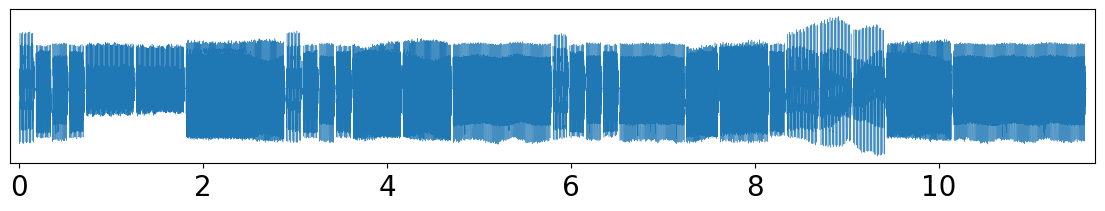

In [10]:
sl_len = len(sound_list)

i=0
fig = plt.figure(figsize=(14,2))
plt.plot((np.arange(0,sl_len,1)/22050)[::5],1000*sound_list[::5]/25,linewidth=0.3)
#plt.plot([(np.arange(0,sl_len,1)/22050)[::5][i],(np.arange(0,sl_len,1)/22050)[::5][i]],[-1,1], color='red' )
plt.xlim([-0.10,11.7])
plt.xticks(fontsize=20)
plt.yticks([])
plt.savefig(f'rick_roll_wave.jpg',dpi=200,bbox_inches = 'tight')

In [11]:
sound_list.shape[0]/16_000

16.0

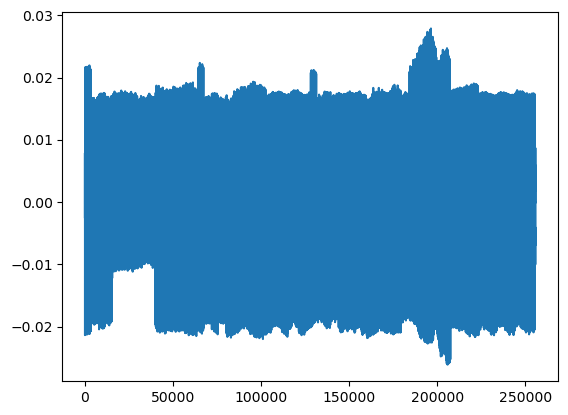

In [12]:
plt.plot(sound_list)

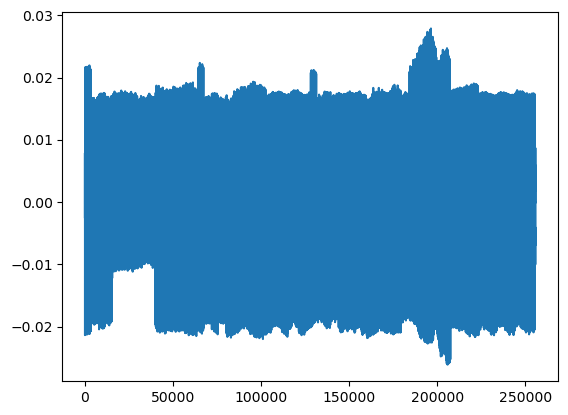

In [13]:
plt.plot(sound_list)

In [14]:
sf.write('audio/never_gonna_give_up_reservoir.mp3',sound_list,22050)

In [16]:

c1=circ_rot([4.5,6])
c2=circ_rot([7.5,6])
c3=circ_rot([3,3])
c4=circ_rot([6,3])
c5=circ_rot([9,3])
c6=circ_rot([3,1])
c7=circ_rot([6,1])
c8=circ_rot([9,1])

c1_dot = c1.pos
c2_dot = c2.pos
c3_dot = c3.pos
c4_dot = c4.pos
c5_dot = c5.pos
c6_dot = c6.pos
c7_dot = c7.pos
c8_dot = c8.pos

c1_legend = circ_rot([13,4])
c2_legend = circ_rot([13,2.5])

c1_legend_dot = c1_legend.pos
c2_legend_dot = c2_legend.pos
i=0
for m,b in zip(M_pro[:27],B_pro[:27]):
    b=int(b)
    m=int(m)
    for _ in range(2*b):
        i+=1
        
        c1_arrow = plt.Arrow(4.5,5.5,0,-0.5,width=0.3,color='red')
        c2_arrow = plt.Arrow(7.5,5.5,0,-0.5,width=0.3,color='red')


        c3_arrow = plt.Arrow(3,4,0,-0.5,width=0.3,color='orange')
        c4_arrow = plt.Arrow(6,4,0,-0.5,width=0.3,color='orange')
        c5_arrow = plt.Arrow(9,4,0,-0.5,width=0.3,color='orange')
        c6_arrow = plt.Arrow(4,4,0,-0.5,width=0.3,color='orange')
        c7_arrow = plt.Arrow(5,4,0,-0.5,width=0.3,color='orange')
        c8_arrow = plt.Arrow(7.5,4,0,-0.5,width=0.3,color='orange')
        
        circle1_legend = plt.Circle((13, 4), 0.5, color='g',fill=False)
        circle2_legend = plt.Circle((13, 2.5), 0.5, color='g',fill=False)
        
        
        circle1 = plt.Circle((4.5, 6), 0.5, color='g',fill=False)
        circle2 = plt.Circle((7.5, 6), 0.5, color='g',fill=False)
        circle3 = plt.Circle((3, 3), 0.5, color='g',fill=False)
        circle4 = plt.Circle((6, 3), 0.5, color='g',fill=False)
        circle5 = plt.Circle((9, 3), 0.5, color='g',fill=False)
        circle6 = plt.Circle((3, 1), 0.5, color='g',fill=False)
        circle7 = plt.Circle((6, 1), 0.5, color='g',fill=False)
        circle8 = plt.Circle((9, 1), 0.5, color='g',fill=False)

        rectangle =  plt.Rectangle((2,4), 8, 1, color='black',fill=False)
        rectangle_sound = plt.Rectangle((0,-3.1), 12, 2.3, color='black',fill=False)
        fig = plt.figure(figsize=(17,7))
        

        
        c1_line = plt.plot([4.5,4.5],[5.5,5],c='red') 
        c2_line = plt.plot([7.5,7.5],[5.5,5],c='red') 
        c3_line = plt.plot([3,3],[4,3.5],c='orange') 
        c4_line = plt.plot([6,6],[4,3.5],c='orange') 
        c5_line = plt.plot([9,9],[4,3.5],c='orange') 
        c6a_line = plt.plot([4,4],[4,1],c='orange') 
        c6b_line = plt.plot([3.5,4],[1,1],c='orange') 
        c7a_line = plt.plot([5,5],[4,1],c='orange') 
        c7b_line = plt.plot([5,5.5],[1,1],c='orange') 
        c8a_line = plt.plot([7.5,7.5],[4,1],c='orange') 
        c8b_line = plt.plot([7.5,8.5],[1,1],c='orange') 

        plt.gca().add_patch(circle1_legend)
        plt.gca().add_patch(circle2_legend)
        plt.gca().add_patch(circle1)
        plt.gca().add_patch(circle2)
        plt.gca().add_patch(circle3)
        plt.gca().add_patch(circle4)
        plt.gca().add_patch(circle5)
        plt.gca().add_patch(circle6)
        plt.gca().add_patch(circle7)
        plt.gca().add_patch(circle8)
        plt.gca().add_patch(rectangle)
        plt.gca().add_patch(c1_arrow)
        plt.gca().add_patch(c2_arrow)
        plt.gca().add_patch(rectangle_sound)
        if m==1:
            plt.gca().add_patch(c3_arrow)
            c3_dot = c3.one_step()
        elif m==2:
            plt.gca().add_patch(c4_arrow)
            c4_dot = c4.one_step()
        elif m==3:
            plt.gca().add_patch(c5_arrow)
            c5_dot = c5.one_step()
        elif m==4:
            plt.gca().add_patch(c6_arrow)
            c6_dot = c6.one_step()
        elif m==5:
            plt.gca().add_patch(c7_arrow)
            c7_dot = c7.one_step()
        elif m==6:
            plt.gca().add_patch(c8_arrow)
            c8_dot = c8.one_step()
        c1_dot = c1.one_step()
        c2_dot = c2.one_step()
        c2_legend_dot = c2_legend.one_step() 
        
        plt.scatter(c1_dot[0],c1_dot[1],s=10,c='#1f77b4')
        plt.scatter(c2_dot[0],c2_dot[1],s=10,c='#1f77b4')
        plt.scatter(c3_dot[0],c3_dot[1],s=10,c='#1f77b4')
        plt.scatter(c4_dot[0],c4_dot[1],s=10,c='#1f77b4')
        plt.scatter(c5_dot[0],c5_dot[1],s=10,c='#1f77b4')
        plt.scatter(c6_dot[0],c6_dot[1],s=10,c='#1f77b4')
        plt.scatter(c7_dot[0],c7_dot[1],s=10,c='#1f77b4')
        plt.scatter(c8_dot[0],c8_dot[1],s=10,c='#1f77b4')
        plt.scatter(c2_legend_dot[0],c2_legend_dot[1],s=10,c='#1f77b4')
        plt.scatter(c1_legend_dot[0],c1_legend_dot[1],s=10,c='#1f77b4')
        
        plt.text(4.3,4.4, f'Beat: {b}/16,    Pitch: {int2let[m]}4',fontsize=18)

        plt.text(0.1,5.8,' sheet music \n oscillator \n networks:',fontsize=14)
        plt.text(0.1,2,' sound \n oscillator \n networks:',fontsize=14)
        plt.text(4.3, 6.7, 'beat')
        plt.text(7.3, 6.7, 'pitch')
        offs=0.1
        plt.text(3-offs,2.2, int2let[1]+'4')
        plt.text(6-offs,2.2, int2let[2]+'4')
        plt.text(9-offs,2.2, int2let[3]+'4')
        plt.text(3-offs,0.2, int2let[4]+'4')
        plt.text(6-offs,0.2, int2let[5]+'4')
        plt.text(9-offs,0.2, int2let[6]+'4')
        
        plt.text(0.1, -0.6, 'oscillator network output (sound wave 22050Hz):', fontsize=14)
        
        plt.text(12.5,6, 'Legend', fontsize=20)
        plt.text(12.5,5.2, 'Kuramoto oscillator network', fontsize=14)
        plt.text(14,4, 'Stationary', fontsize=14)
        plt.text(14,2.5, 'Evolving', fontsize=14)
        plt.plot([12,12],[0,7],'--')
        plt.axis('off')
        
        plt.xlim([0,19])
        plt.ylim([-3.3,7.1])
        
        plt.plot((np.arange(0,sl_len,1)/22050)[::5]+0.25,1000*sound_list[::5]/25-2,linewidth=0.3, c='#1f77b4')
        plt.plot([(np.arange(0,sl_len,1)/22050)[(i-1)*2000]+0.25,(np.arange(0,sl_len,1)/22050)[(i-1)*2000]+0.25],[-0.85,-3.1], color='red' )
        #plt.xlim([-0.10,11.7])
        plt.gca().set_aspect('equal')
        #plt.text(6,6,f'{i}')

        if i<=9:
            plt.savefig(f'images/000{i}.jpg',dpi=240,bbox_inches = 'tight')
            plt.close()
        elif i<=99:
            plt.savefig(f'images/00{i}.jpg',dpi=240,bbox_inches = 'tight')
            plt.close()
        elif i<=999:
            plt.savefig(f'images/0{i}.jpg',dpi=240,bbox_inches = 'tight')
            plt.close()
        elif i<=9999:
            plt.savefig(f'images/{i}.jpg',dpi=240,bbox_inches = 'tight')
            plt.close()


In [17]:
sl_len/128

2000.0

In [18]:
name_list = []
for i in range(1,128):
    if i<=9:
        name_list.append(f'000{i}.jpg')
    elif i<=99:
        name_list.append(f'00{i}.jpg')
    elif i<=999:
        name_list.append(f'0{i}.jpg')
    elif i<=9999:
        name_list.append(f'{i}.jpg')


In [19]:
os.chdir('D:\\GitHub\\reservoir_dummy_paper\\supp\\music_box') 

In [20]:
audio_path = 'audio/never_gonna_give_up_reservoir.mp3' 
video_path = os.path.join(os.getcwd(), "video") 
images_path = os.path.join(os.getcwd(), "images") 
audio = MP3(audio_path) 
audio_length = audio.info.length 

list_of_images = []

for image_file in name_list: 
    if image_file.endswith('.jpg'): 
        image_path = os.path.join(images_path, image_file) 
        image = Image.open(image_path).resize((int(19*200), int(10.4*200)), Image.ANTIALIAS) 
        list_of_images.append(image) 
  


In [21]:
audio_length

11.609977324263038

In [22]:
duration = audio_length/len(list_of_images) 
imageio.mimsave('images.gif', list_of_images, fps=1/duration) 

In [23]:
  
video = editor.VideoFileClip("images.gif") 
audio = editor.AudioFileClip(audio_path) 
final_video = video.set_audio(audio) 
final_video.write_videofile(fps=60, codec="libx264", filename="never_gonna_give_up.mp4") 

Moviepy - Building video never_gonna_give_up.mp4.
MoviePy - Writing audio in never_gonna_give_upTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video never_gonna_give_up.mp4



Moviepy - Done !
Moviepy - video ready never_gonna_give_up.mp4
